In [1]:
import os
import pandas as pd
import numpy as np 
import pingouin as pg 
from statsmodels.graphics.factorplots import interaction_plot 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [2]:
def Get_participants(folder_dir) : 
    participants = os.listdir(folder_dir)
    participants = sorted([ x.split(sep=".")[0] for x in participants if x.endswith(".csv") and not x.startswith(".")])
    
    return participants


def Partis_Dict(folder_dir) : 

    participants = Get_participants( folder_dir )

    participants_dict = { x : None for x  in participants} 
    
    for parti in participants_dict:
        arr = np.loadtxt( folder_dir + "/" + parti + ".csv", delimiter=",", dtype=float)
        
        participants_dict[parti] = arr
    
    return participants_dict


def get_dispersion(x, y) : 
    
    dispersion = ( np.max(x) - np.min(x) ) + (np.max(y) - np.min(y))

    return  dispersion

def get_fixation( position_arr, viewing_distance = 3, dispersion = 1.35, duration = 10):
    
    dispersion_threshold = 2 * np.tan( dispersion * np.pi / 180) * viewing_distance # fixation limit viweing angle : 1

    duration_threshold = duration 

    fixation_arr = []
    
    position_num = 0
    saccade = 0 

    while position_num + duration_threshold <= len(position_arr) :

        fixation_range = position_arr[position_num : position_num + duration_threshold]
        dispersion = get_dispersion(fixation_range[:,0], fixation_range[:,1] )

        if dispersion < dispersion_threshold :
            
            while dispersion < dispersion_threshold and position_num + duration_threshold <= len(position_arr):
                duration_threshold += 1
                fixation_range = position_arr[position_num : position_num + duration_threshold]
                dispersion = get_dispersion(fixation_range[:,0], fixation_range[:,1] )

            fixation_arr.append([position_num, duration_threshold, saccade])

            # reset window
            position_num = position_num + duration_threshold
            duration_threshold = duration
            saccade = 0

        else : # dispersion >= dispersion_threshold
            saccade += 1 
            position_num += 1
            duration_threshold = duration


    return np.array(fixation_arr)


In [3]:
curr_dir = os.getcwd() 
gaze_dir = curr_dir + "/Gaze"
X_dir = gaze_dir + "/X_data"
Y_dir = gaze_dir + "/Y_data"

x = Partis_Dict(X_dir)
y = Partis_Dict(Y_dir)

gaze = { parti : np.array([x[parti], y[parti]]) for parti in x.keys() }

print(len(gaze)) # 참가자 수 
print( gaze[next(iter(gaze.keys()))].shape) # ((x,y), frame_num == 11950 , video_num == 16)

52
(2, 11950, 16)


In [4]:
fixation = { parti : None for parti in gaze.keys() }

for participant in gaze.keys() : 
    
    gaze_data = gaze[participant].transpose(2,1,0) # (video_num, frame_num, (x,y))
    fix_arr = []

    for video_num in range(len(gaze_data)) :
        fix_arr.append(get_fixation(gaze_data[video_num]))

    fixation[participant] = np.array(fix_arr)

# for video_num in range(len(gaze_data)):
#     print(fixation[next(iter(fixation.keys()))][video_num].shape)

[125.27403846 113.86538462 144.20673077 125.14903846]


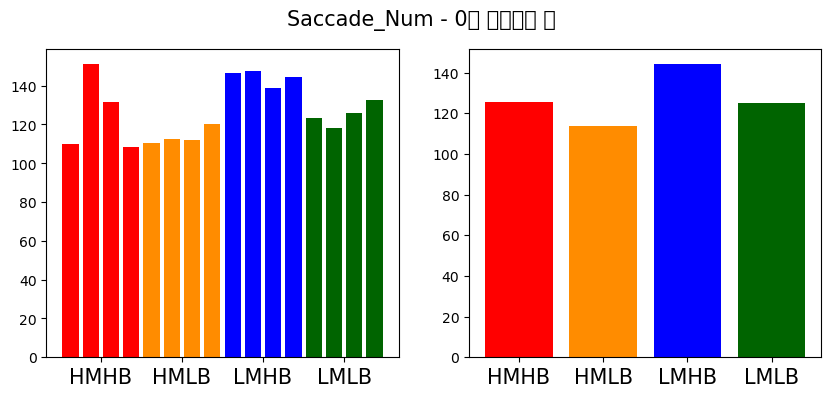

In [5]:
# Saccade_Num - 0을 제거했을 때

avg_sac_num =  np.array([ [  len(fixation[parti][video_num][fixation[parti][video_num][:,2]!=0]) for video_num in range(16)  ] for parti in fixation.keys()])

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,4)

axs[0].bar( range(len(avg_sac_num.mean(0))), avg_sac_num.mean(axis=0), color = np.repeat(colors, 4))
axs[0].set_xticks([ 1.5, 5.5, 9.5, 13.5], block_names, fontsize = 15);

axs[1].bar(range(4), avg_sac_num.mean(0).reshape(-1,4).mean(axis=1), color = colors)
axs[1].set_xticks(range(4), block_names, fontsize = 15);

fig.suptitle("Saccade_Num - 0을 제거했을 때", fontsize = 15);

print(avg_sac_num.mean(0).reshape(-1,4).mean(axis=1))

In [6]:
# Saccade_Num - 0을 제거했을 때

data = avg_sac_num.reshape(-1,4,4).mean(axis=2).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_sac_num)
names = np.repeat(np.arange(len(avg_sac_num)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

print("Saccade_Num - 0을 제거했을 때")
print("-"*100,'\n')
results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
print(results)


post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
print("-"*100,'\n')
print(post_hoc[['A', 'B', 'T', 'p-unc']])
print("="*100,'\n') 

Saccade_Num - 0을 제거했을 때
---------------------------------------------------------------------------------------------------- 

   Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  blocks      3    153  20.437432  3.429883e-11  5.290950e-11  0.070115   

        eps  sphericity   W-spher   p-spher  
0  0.979022        True  0.968759  0.903893  
---------------------------------------------------------------------------------------------------- 

      A     B         T         p-unc
0  HMHB  HMLB  2.921412  5.180328e-03
1  HMHB  LMHB -4.690958  2.073276e-05
2  HMHB  LMLB  0.032695  9.740457e-01
3  HMLB  LMHB -7.120149  3.515820e-09
4  HMLB  LMLB -2.927447  5.095214e-03
5  LMHB  LMLB  5.133703  4.485155e-06



In [7]:
avg_fixation_num =  np.array([ [  len(fixation[parti][video_num]) for video_num in range(16)  ] for parti in fixation.keys()])
se_fix_num = [ np.std(avg_fixation_num.mean(axis=0)[x:x+4]) / np.sqrt(4) for x in range(0,16,4)]

data = avg_fixation_num.reshape(-1,4,4).mean(axis=2).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_fixation_num)
names = np.repeat(np.arange(len(avg_fixation_num)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

print("Saccade_Num(Fixation_Num)")
print("-"*100,'\n')
results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
print(results)

post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
print("-"*100,'\n')
print(post_hoc[['A','B','T','p-unc']].round(3))
print("="*100,'\n') 

Saccade_Num(Fixation_Num)
---------------------------------------------------------------------------------------------------- 

   Source  ddof1  ddof2         F         p-unc     p-GG-corr      ng2  \
0  blocks      3    153  41.89597  8.020888e-20  4.806436e-18  0.13166   

        eps  sphericity  W-spher   p-spher  
0  0.897944        True  0.83475  0.109888  
---------------------------------------------------------------------------------------------------- 

      A     B      T  p-unc
0  HMHB  HMLB  7.477  0.000
1  HMHB  LMHB  6.861  0.000
2  HMHB  LMLB  9.559  0.000
3  HMLB  LMHB  1.182  0.243
4  HMLB  LMLB  4.554  0.000
5  LMHB  LMLB  3.693  0.001



In [8]:
avg_fixation_num.shape

(52, 16)

In [9]:
HM = [0,1,2,3,4,5,6,7]
LM = [8,9,10,11,12,13,14,15]
HB = [0,1,2,3,8,9,10,11]
LB = [4,5,6,7,12,13,14,15]

print("[Motion]")
print(pg.ttest(avg_fixation_num.mean(axis=0)[LM].flatten(), avg_fixation_num.mean(axis=0)[HM].flatten(), paired= True, alternative='less').iloc[:,:4])
print("-"*50)
print("\n")
print("[Brightness]")
print(pg.ttest(avg_fixation_num.mean(axis=0)[LB].flatten(), avg_fixation_num.mean(axis=0)[HB].flatten(), paired= True, alternative='less' ).iloc[:,:4])
print("-"*50)

[Motion]
               T  dof alternative     p-val
T-test -3.086826    7        less  0.008823
--------------------------------------------------


[Brightness]
               T  dof alternative     p-val
T-test -2.279411    7        less  0.028343
--------------------------------------------------


[125.27403846 113.86538462 144.20673077 125.14903846]


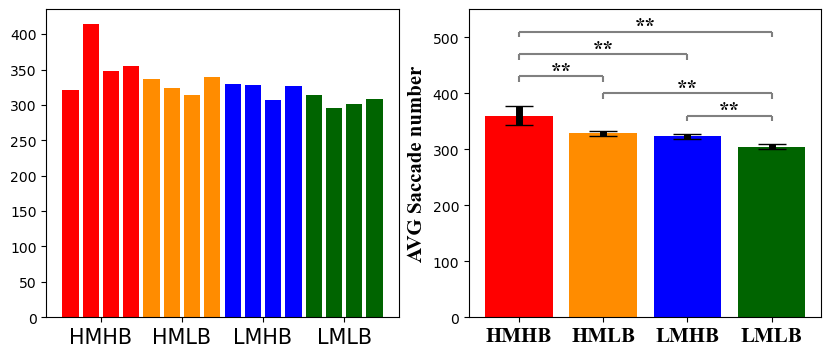

In [10]:
avg_fixation_num =  np.array([ [  len(fixation[parti][video_num]) for video_num in range(16)  ] for parti in fixation.keys()])
se_fix_num = [ np.std(avg_fixation_num.mean(axis=0)[x:x+4]) / np.sqrt(4) for x in range(0,16,4)]

def singnificantLine(ax, x1, x2, y, text, vline = 10 ,font_size = 15, ha_ = 'center',family_ = 'Times New Roman', weight_ ='bold' ):
    ax.hlines(y, x1, x2, colors='gray', linestyles='solid')
    ax.vlines(x1, y, y-vline, colors='gray', linestyles='solid')
    ax.vlines(x2, y, y-vline, colors='gray', linestyles='solid')
    ax.text( (x1+x2)/2, y, text, fontsize = font_size, ha = ha_,family = family_, weight=weight_)

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
font_dict = {'family': 'Times New Roman',
      'color':  'black',
      'weight': 'bold',
      'size': 15,
      'va' : 'center',
      'ha' : 'center' }

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,4)

axs[0].bar( range(len(avg_fixation_num.mean(0))), avg_fixation_num.mean(axis=0), color = np.repeat(colors, 4))
axs[0].set_xticks([ 1.5, 5.5, 9.5, 13.5], block_names,fontsize = 15);

axs[1].bar(range(4), avg_fixation_num.mean(0).reshape(-1,4).mean(axis=1), color = colors)
axs[1].set_xticks(range(4), block_names, fontsize = 15, family = "Times New Roman", weight ='bold');
axs[1].set_ylabel("AVG Saccade number", fontsize = 15,family = "Times New Roman", weight='bold' );
axs[1].set_ylim(0,550)
axs[1].errorbar(range(4), avg_fixation_num.mean(0).reshape(-1,4).mean(axis=1), yerr = se_fix_num, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
singnificantLine(axs[1], 0, 3, 510, '**')
singnificantLine(axs[1], 0, 2, 470, '**')
singnificantLine(axs[1], 0, 1, 430, '**')
singnificantLine(axs[1], 1, 3, 400, '**')
singnificantLine(axs[1], 2, 3, 360, '**')


# y = avg_fixation_num.mean(0).reshape(-1,4).mean(axis=1)
# for i, blc in enumerate( y ): 
#     plt.text(x = i, y= y[i] + 35, s= round(blc, 2), fontdict=font_dict, color='black')
    
# fig.suptitle("Saccade(Fixation)_Num", fontsize = 15);

print(avg_sac_num.mean(0).reshape(-1,4).mean(axis=1))

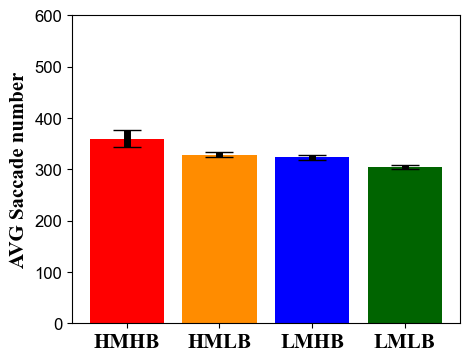

In [11]:
fig = plt.figure(figsize=(5,4))

plt.bar(range(4), avg_fixation_num.mean(0).reshape(-1,4).mean(axis=1), color = colors)
plt.xticks(range(4), block_names, fontsize = 15, family = "Times New Roman", weight ='bold');
plt.ylabel("AVG Saccade number", fontsize = 15,family = "Times New Roman", weight='bold' );
plt.ylim(0,600)
plt.yticks( family = 'Arial', fontsize= 12)
plt.errorbar(range(4), avg_fixation_num.mean(0).reshape(-1,4).mean(axis=1), yerr = se_fix_num, linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
# singnificantLine(plt, 0, 3, 510, '**')
# singnificantLine(plt, 0, 2, 470, '**')
# singnificantLine(plt, 0, 1, 430, '**')
# singnificantLine(plt, 1, 3, 400, '**')
# singnificantLine(plt, 2, 3, 360, '**')
# plt.text(-0.3, 540,'(b)', ha ='center', fontsize = 20, family = 'Arial', weight='bold' );


In [12]:
avg_fixation_duration = [ ]
avg_saccade_duration = []

for participant in fixation : 
    fixation_data = fixation[participant]
    
    particiapnt_fix = []
    particiapnt_sac = []

    for video_num in range(len(fixation_data)) : 
        fix = fixation_data[video_num][:,1]
        sac = fixation_data[video_num][:,2]
        particiapnt_fix.append(fix.mean())
        particiapnt_sac.append(sac.mean())
        #particiapnt_sac.append(sac[ sac != 0].mean())

    avg_fixation_duration.append(particiapnt_fix)
    avg_saccade_duration.append(particiapnt_sac)

avg_fixation_duration = np.array(avg_fixation_duration) * 10
avg_saccade_duration = np.array(avg_saccade_duration) * 10

print(avg_fixation_duration.shape)
print(avg_saccade_duration.shape)


(52, 16)
(52, 16)


In [13]:
data = avg_fixation_duration.reshape(-1,4,4).mean(axis=2).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_fixation_num)
names = np.repeat(np.arange(len(avg_fixation_num)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)

print("Fixation_Duration")
print("-"*100,'\n')

print(results)


post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')


print("-"*100,'\n')
print(post_hoc[['A','B','T','p-unc']].round(3))
print("="*100,'\n') 

Fixation_Duration
---------------------------------------------------------------------------------------------------- 

   Source  ddof1  ddof2          F         p-unc     p-GG-corr       ng2  \
0  blocks      3    153  21.159058  1.608719e-11  3.926273e-09  0.084443   

        eps  sphericity   W-spher   p-spher  
0  0.743619       False  0.602442  0.000128  
---------------------------------------------------------------------------------------------------- 

      A     B      T  p-unc
0  HMHB  HMLB -4.813  0.000
1  HMHB  LMHB -4.766  0.000
2  HMHB  LMLB -6.072  0.000
3  HMLB  LMHB -1.348  0.184
4  HMLB  LMLB -4.002  0.000
5  LMHB  LMLB -3.281  0.002



In [14]:
data = avg_saccade_duration.reshape(-1,4,4).mean(axis=2).flatten()
blocks = [ "HMHB", "HMLB", "LMHB", "LMLB"] * len(avg_fixation_num)
names = np.repeat(np.arange(len(avg_fixation_num)),4)

df = pd.DataFrame( { 'names' : names, 'rating' : data, 'blocks': blocks})

print("Saccade_Duration")
print("-"*100,'\n')

results = pg.rm_anova( data= df, dv='rating', within='blocks', subject='names', correction=True)
print(results)


post_hoc = pg.pairwise_tests(data= df, dv='rating', within='blocks', subject='names', padjust='bonf')
print("-"*100,'\n')
print(post_hoc[['A','B','T','p-unc']])
print("="*100,'\n') 

Saccade_Duration
---------------------------------------------------------------------------------------------------- 

   Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  blocks      3    153  3.954147  0.009473   0.017143  0.018962  0.767045   

   sphericity   W-spher   p-spher  
0       False  0.528757  0.000007  
---------------------------------------------------------------------------------------------------- 

      A     B         T     p-unc
0  HMHB  HMLB -2.014649  0.049229
1  HMHB  LMHB -4.335956  0.000068
2  HMHB  LMLB -2.747034  0.008290
3  HMLB  LMHB -0.946255  0.348481
4  HMLB  LMLB -0.822952  0.414367
5  LMHB  LMLB  0.123636  0.902090



In [15]:
HM = [0,1,2,3,4,5,6,7]
LM = [8,9,10,11,12,13,14,15]
HB = [0,1,2,3,8,9,10,11]
LB = [4,5,6,7,12,13,14,15]

print("[Motion]")
print(pg.ttest(avg_fixation_duration.mean(axis=0)[LM].flatten(), avg_fixation_duration.mean(axis=0)[HM].flatten(), paired= True, alternative='greater').iloc[:,:4])
print("-"*50)
print("\n")
print("[Brightness]")
print(pg.ttest(avg_fixation_duration.mean(axis=0)[LB].flatten(), avg_fixation_duration.mean(axis=0)[HB].flatten(), paired= True, alternative='greater' ).iloc[:,:4])
print("-"*50)

[Motion]
               T  dof alternative     p-val
T-test  3.501707    7     greater  0.004985
--------------------------------------------------


[Brightness]
               T  dof alternative     p-val
T-test  2.373858    7     greater  0.024663
--------------------------------------------------


In [16]:
HM = [0,1,2,3,4,5,6,7]
LM = [8,9,10,11,12,13,14,15]
HB = [0,1,2,3,8,9,10,11]
LB = [4,5,6,7,12,13,14,15]

print("[Motion]")
print(pg.ttest(avg_saccade_duration.mean(axis=0)[LM].flatten(), avg_saccade_duration.mean(axis=0)[HM].flatten(), paired= True, alternative='greater').iloc[:,:4])
print("-"*50)
print("\n")
print("[Brightness]")
print(pg.ttest(avg_saccade_duration.mean(axis=0)[LB].flatten(), avg_saccade_duration.mean(axis=0)[HB].flatten(), paired= True, alternative='greater' ).iloc[:,:4])
print("-"*50)

[Motion]
               T  dof alternative    p-val
T-test  3.253998    7     greater  0.00699
--------------------------------------------------


[Brightness]
               T  dof alternative     p-val
T-test  1.686762    7     greater  0.067755
--------------------------------------------------


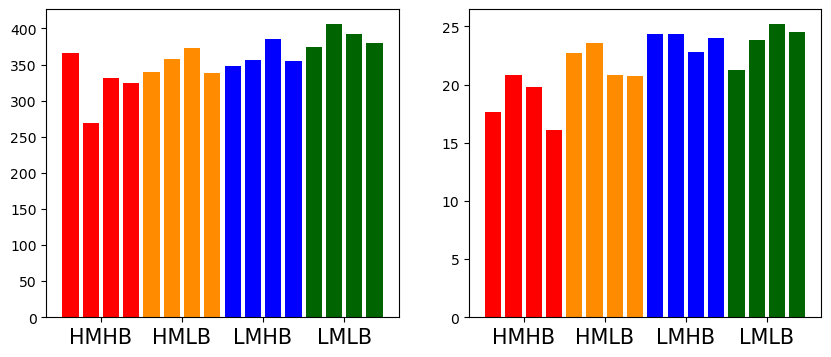

In [17]:
fix_sac = np.array([avg_fixation_duration.mean(axis=0), avg_saccade_duration.mean(axis=0)])

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
titles = [ "Fixation_Duration", "Saccade_Duration"]

fig, axs = plt.subplots(1,2) 
fig.set_size_inches(10,4)
for ind, ax in enumerate(axs) : 
    ax.bar( range(len(fix_sac[ind])), fix_sac[ind], color = np.repeat(colors,4) )
    ax.set_xticks([ 1.5, 5.5, 9.5, 13.5], block_names, fontsize = 15)
    #ax.set_title(titles[ind], fontsize = 15) 

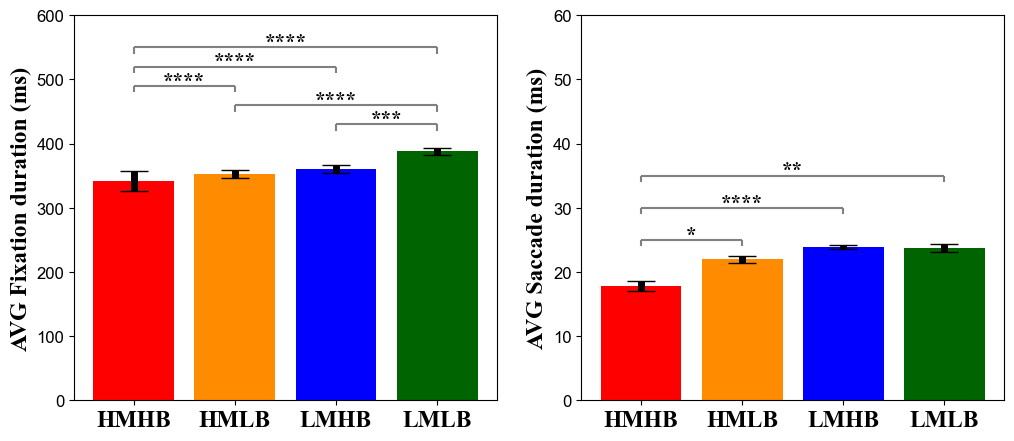

In [18]:
fix_sac = [avg_fixation_duration.mean(axis=0), avg_saccade_duration.mean(axis=0)]
fix_sac[0][1] = fix_sac[0][[0,2,3]].mean() 
fix_sac[1][1] = fix_sac[1][[0,2,3]].mean() 

fix_sac[0] = np.array(fix_sac[0]).reshape(-1,4).mean(axis=1)
fix_sac[1] = np.array(fix_sac[1]).reshape(-1,4).mean(axis=1)

colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']
titles = [ "AVG Fixation duration (ms)", "AVG Saccade duration (ms)"]
se = [  [ np.std(avg_fixation_duration.mean(axis=0)[x:x+4]) / np.sqrt(5) for x in range(0,16,4)], \
    [ np.std(avg_saccade_duration.mean(axis=0)[x:x+4]) / np.sqrt(5) for x in range(0,16,4)] ]
ylim = [600, 60]
adding = [ 30, 4]


fig, axs = plt.subplots(1,2) 
fig.set_size_inches(12,5)
for ind, ax in enumerate(axs) : 
    ax.bar( range(len(fix_sac[ind])), fix_sac[ind], color = colors )
    ax.set_ylabel(titles[ind], fontsize = 17,family = "Times New Roman", weight='bold' );
    ax.set_xticks(range(len(fix_sac[ind])), block_names, fontsize = 17, family = "Times New Roman", weight = 'bold')
    ax.set_ylim(0,ylim[ind])
    ax.set_yticklabels(ax.get_yticks().astype(int) , family = 'Arial', fontsize= 12)
    ax.errorbar(range(4),fix_sac[ind] ,yerr = np.round(se[ind], 2), linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 
    y = fix_sac[ind] + adding[ind]

singnificantLine(axs[0],0,3, 550,'****')
singnificantLine(axs[0],0,2, 520,'****')
singnificantLine(axs[0],0,1, 490,'****')
singnificantLine(axs[0],1,3, 460,'****')
singnificantLine(axs[0],2,3, 430,'***')

singnificantLine(axs[1],0,3, 35,'**', vline= 1)
singnificantLine(axs[1],0,2, 30,'****', vline= 1)
singnificantLine(axs[1],0,1, 25,'*', vline= 1)
    
    # for i, blc in enumerate(fix_sac[ind]): 
    #     ax.text(x = i, y= y[i], s = round(blc, 2), fontdict=font_dict, color='black')
    
    # ax.set_title(titles[ind], fontsize = 15)

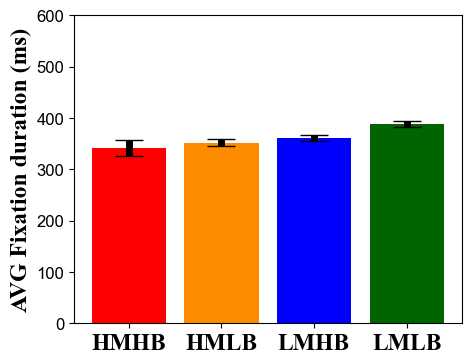

In [19]:
fig = plt.figure(figsize=(5,4))

plt.bar( range(len(fix_sac[0])), fix_sac[0], color = colors )
plt.ylabel(titles[0], fontsize = 17,family = "Times New Roman", weight='bold' );
plt.xticks(range(len(fix_sac[0])), block_names, fontsize = 17, family = "Times New Roman", weight = 'bold')
plt.ylim(0,600)
plt.yticks( family = 'Arial', fontsize= 12)
plt.errorbar(range(4),fix_sac[0] ,yerr = np.round(se[0], 2), linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 

# singnificantLine(plt,0,3, 550,'**')
# singnificantLine(plt,0,2, 520,'**')
# singnificantLine(plt,0,1, 490,'**') 
# singnificantLine(plt,1,3, 460,'**')
# singnificantLine(plt,2,3, 430,'**')

# plt.text(-0.3, 540,'(c)', ha ='center', fontsize = 20, family = 'Arial', weight='bold' );

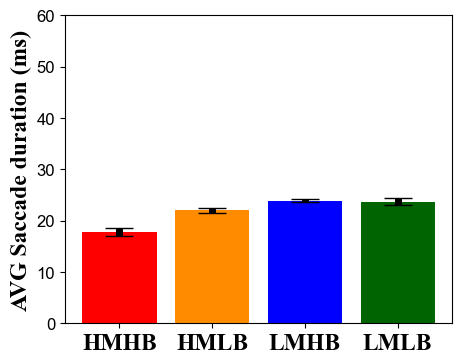

In [20]:
fig = plt.figure(figsize=(5,4))

plt.bar( range(len(fix_sac[1])), fix_sac[1], color = colors )
plt.ylabel(titles[1], fontsize = 17,family = "Times New Roman", weight='bold' );
plt.xticks(range(len(fix_sac[1])), block_names, fontsize = 17, family = "Times New Roman", weight = 'bold')
plt.ylim(0,60)
plt.yticks( family = 'Arial', fontsize= 12)
plt.errorbar(range(4),fix_sac[1] ,yerr = np.round(se[1], 2), linestyle = 'None',capsize=10, capthick=1,elinewidth=5, color='black'); 


# singnificantLine(plt,0,3, 35,'**', vline= 1)
# singnificantLine(plt,0,2, 30,'**', vline= 1)
# singnificantLine(plt,0,1, 25,'*', vline= 1)

# plt.text(-0.3, 54,'(d)', ha ='center', fontsize = 20, family = 'Arial', weight='bold' );

In [21]:
print(avg_fixation_duration.shape)
print(avg_fixation_num.shape)
print(avg_saccade_duration.shape)

HMHB = [0,1,2,3]
HMLB = [4,5,6,7]
LMHB = [8,9,10,11]
LMLB = [12,13,14,15]

Motion = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0] * 52 
Brightness = [1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0] * 52

titles = [ "Fixation duration", "Saccade number", "Saccade duration"]

(52, 16)
(52, 16)
(52, 16)


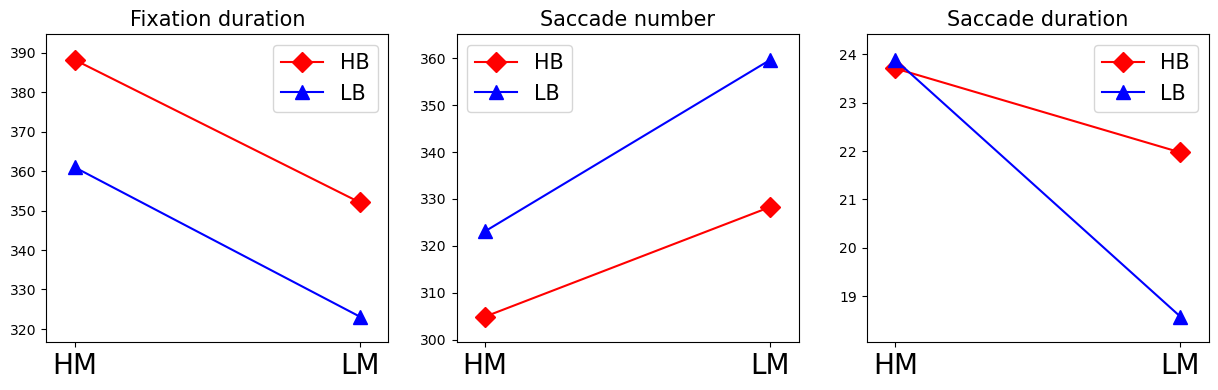

In [22]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,4)

for ind, data in enumerate([avg_fixation_duration, avg_fixation_num, avg_saccade_duration]) :
    interaction_plot( x = Motion, trace= Brightness, response= data.flatten(), ax= axs[ind],colors=['red','blue'], markers=['D','^'], ms=10 )
    axs[ind].set_xticks([0,1], ["HM","LM"], fontsize = 20)
    axs[ind].set_xlabel("")
    axs[ind].set_ylabel("")
    axs[ind].set_title(titles[ind], fontsize =15)
    axs[ind].legend(["HB","LB"], fontsize=15)

In [23]:
len(fixation.keys())

52

In [24]:
# Normal window analysis

sampling_rate = 100
video_len = 120 
window_size = 1

window_arr = []

for particiapant in fixation : 

    parti_data = fixation[particiapant] 

    video_arr = [ ]
    for video_num in range(len(parti_data)): 
        
        data_arr = [ ]
        for index in range(video_len - window_size + 1) : 

            if index < (video_len - window_size) : 
                data = parti_data[video_num]
                arr = data[np.argwhere((data[:,0] >= index * sampling_rate) & (data[:,0] <= index * sampling_rate + window_size * sampling_rate)).flatten()]
                data_arr.append([arr.shape[0], arr.mean(axis=0)[1],arr.mean(axis=0)[2] ])

            else :
                data = parti_data[video_num]
                arr = data[np.where((data[:,0] >= index * sampling_rate))]
                data_arr.append([arr.shape[0], arr.mean(axis=0)[1],arr.mean(axis=0)[2] ])



        video_arr.append(data_arr)

    window_arr.append(video_arr)

window_arr = np.array(window_arr)

window_arr.shape # ( participants, video_num, windows, (fix_num, fix_duration, sac_duration) )

(52, 16, 120, 3)

In [35]:
data_names = [ "Fixation_number", "Fixation_duration", "Saccade_duration"]

for data_index, data_name in enumerate(data_names) : 
    save_dir = os.getcwd() + f"/Window_data/{data_name}"

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    data = window_arr[...,data_index]

    for ind, participant in enumerate(data) :
        np.savetxt(save_dir + f"/{ind}.csv", participant, delimiter = ",")

In [25]:
window_arr = np.where( np.isnan(window_arr), 0, window_arr)
window_arr.shape

(52, 16, 120, 3)

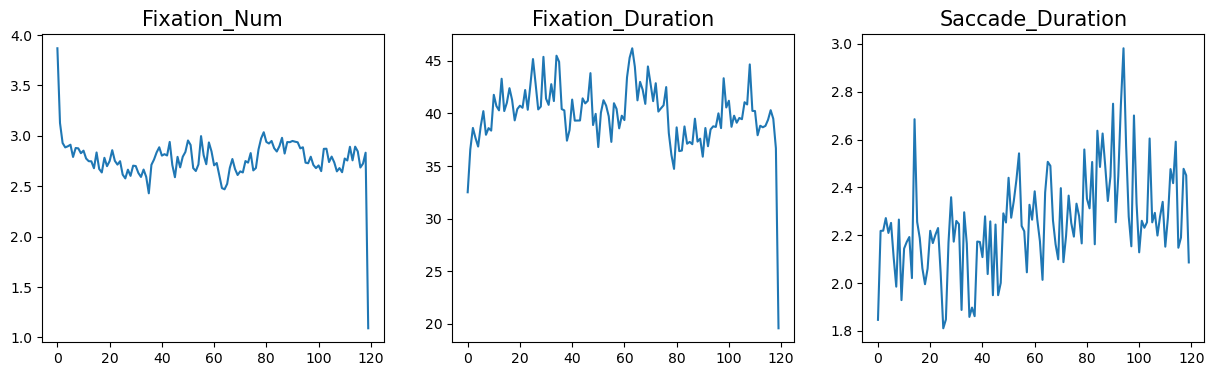

In [26]:
fix_data = window_arr.mean(axis=(0,1)).T


data_names = [ "Fixation_Num", "Fixation_Duration", "Saccade_Duration"]

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,4)

axs = axs.ravel()

for ind, ax in enumerate(axs) : 
    data = fix_data[ind]
    ax.plot(range(len(data)),data)
    ax.set_title(data_names[ind], fontsize=15)


(3, 120, 4)


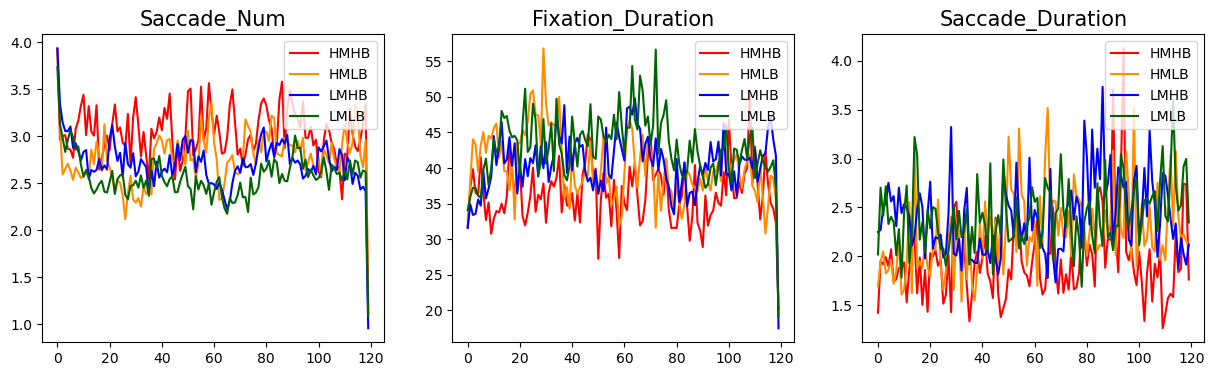

In [27]:
fix_data = window_arr.mean(axis=0).transpose(2,1,0)
fix_data = fix_data.reshape(fix_data.shape[0], fix_data.shape[1], -1, 4).mean(axis=3)
print(fix_data.shape)

data_names = [ "Saccade_Num", "Fixation_Duration", "Saccade_Duration"]
colors = ['r', 'darkorange', 'b', 'darkgreen']
block_names = ['HMHB','HMLB','LMHB','LMLB']

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,4)

axs = axs.ravel()

for ind, ax in enumerate(axs) : 
    data = fix_data[ind]

    for block_ind in range(data.shape[1]): 
        ax.plot(range(len(data)),data[:,block_ind], color = colors[block_ind])
    ax.set_title(data_names[ind], fontsize=15)
    ax.legend( block_names, loc = 1)

(3, 120, 2)


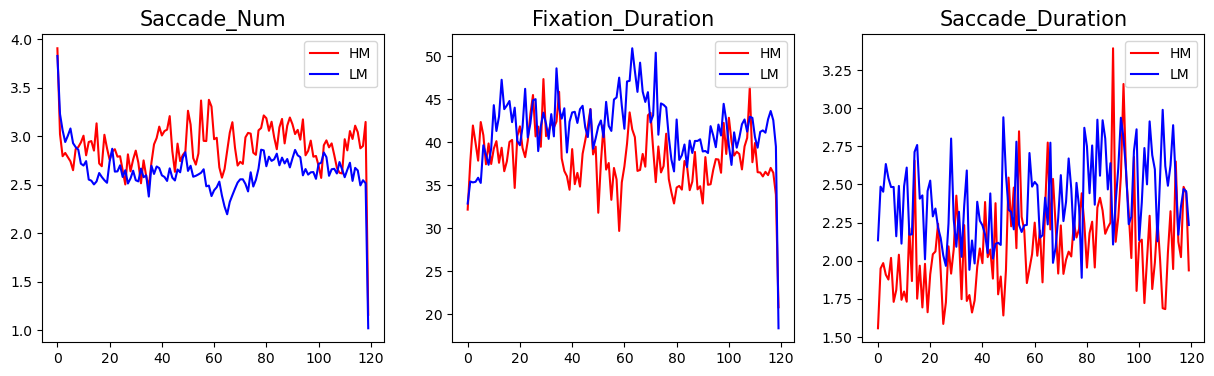

In [28]:
fix_data = window_arr.mean(axis=0).transpose(2,1,0) # data ,window,video

fix_num = np.array([fix_data[0][:, x:x+8].mean(axis=1) for x in range(0,16,8) ]).T
fix_dur = np.array([fix_data[1][:, x:x+8].mean(axis=1) for x in range(0,16,8) ]).T
#sac_dur = np.array([ fix_data[2][:,[0,1,2,3,8,9,10,11]].mean(axis=1), fix_data[2][:,[4,5,6,7,12,13,14,15]].mean(axis=1)]).T 

sac_dur = np.array([fix_data[2][:, x:x+8].mean(axis=1) for x in range(0,16,8) ]).T
block_names = ["HM", "LM"] 
colors = ['r','b']


fix_data = np.array([ fix_num, fix_dur, sac_dur])
print(fix_data.shape)

data_names = [ "Saccade_Num", "Fixation_Duration", "Saccade_Duration"]

fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,4)

axs = axs.ravel()

for ind, ax in enumerate(axs) : 
    data = fix_data[ind]

    # block_names = ["HM", "LM"] if ind != len(axs)-1 else ["HB", "LB"]
    # colors = ['r','b'] if ind != len(axs)-1 else ["darkorange", "darkgreen"]

    for block_ind in range(data.shape[1]): 
        ax.plot(range(len(data)),data[:,block_ind], color = colors[block_ind])
    ax.set_title(data_names[ind], fontsize=15)
    ax.legend( block_names, loc = 1)


In [29]:
avg_data = [ avg_fixation_num, avg_fixation_duration, avg_saccade_duration]
data_names = [ "Fixation_Num", "Fixation_Duration", "Saccade_Duration"]
AVG_dir = curr_dir + "/AVG"

if not os.path.isdir(AVG_dir):
    os.mkdir(AVG_dir)

for ind, data in enumerate(avg_data) :
    df = pd.DataFrame(data)
    df.to_csv(AVG_dir + f"/{data_names[ind]}.csv")

IndexError: index 52 is out of bounds for axis 0 with size 52

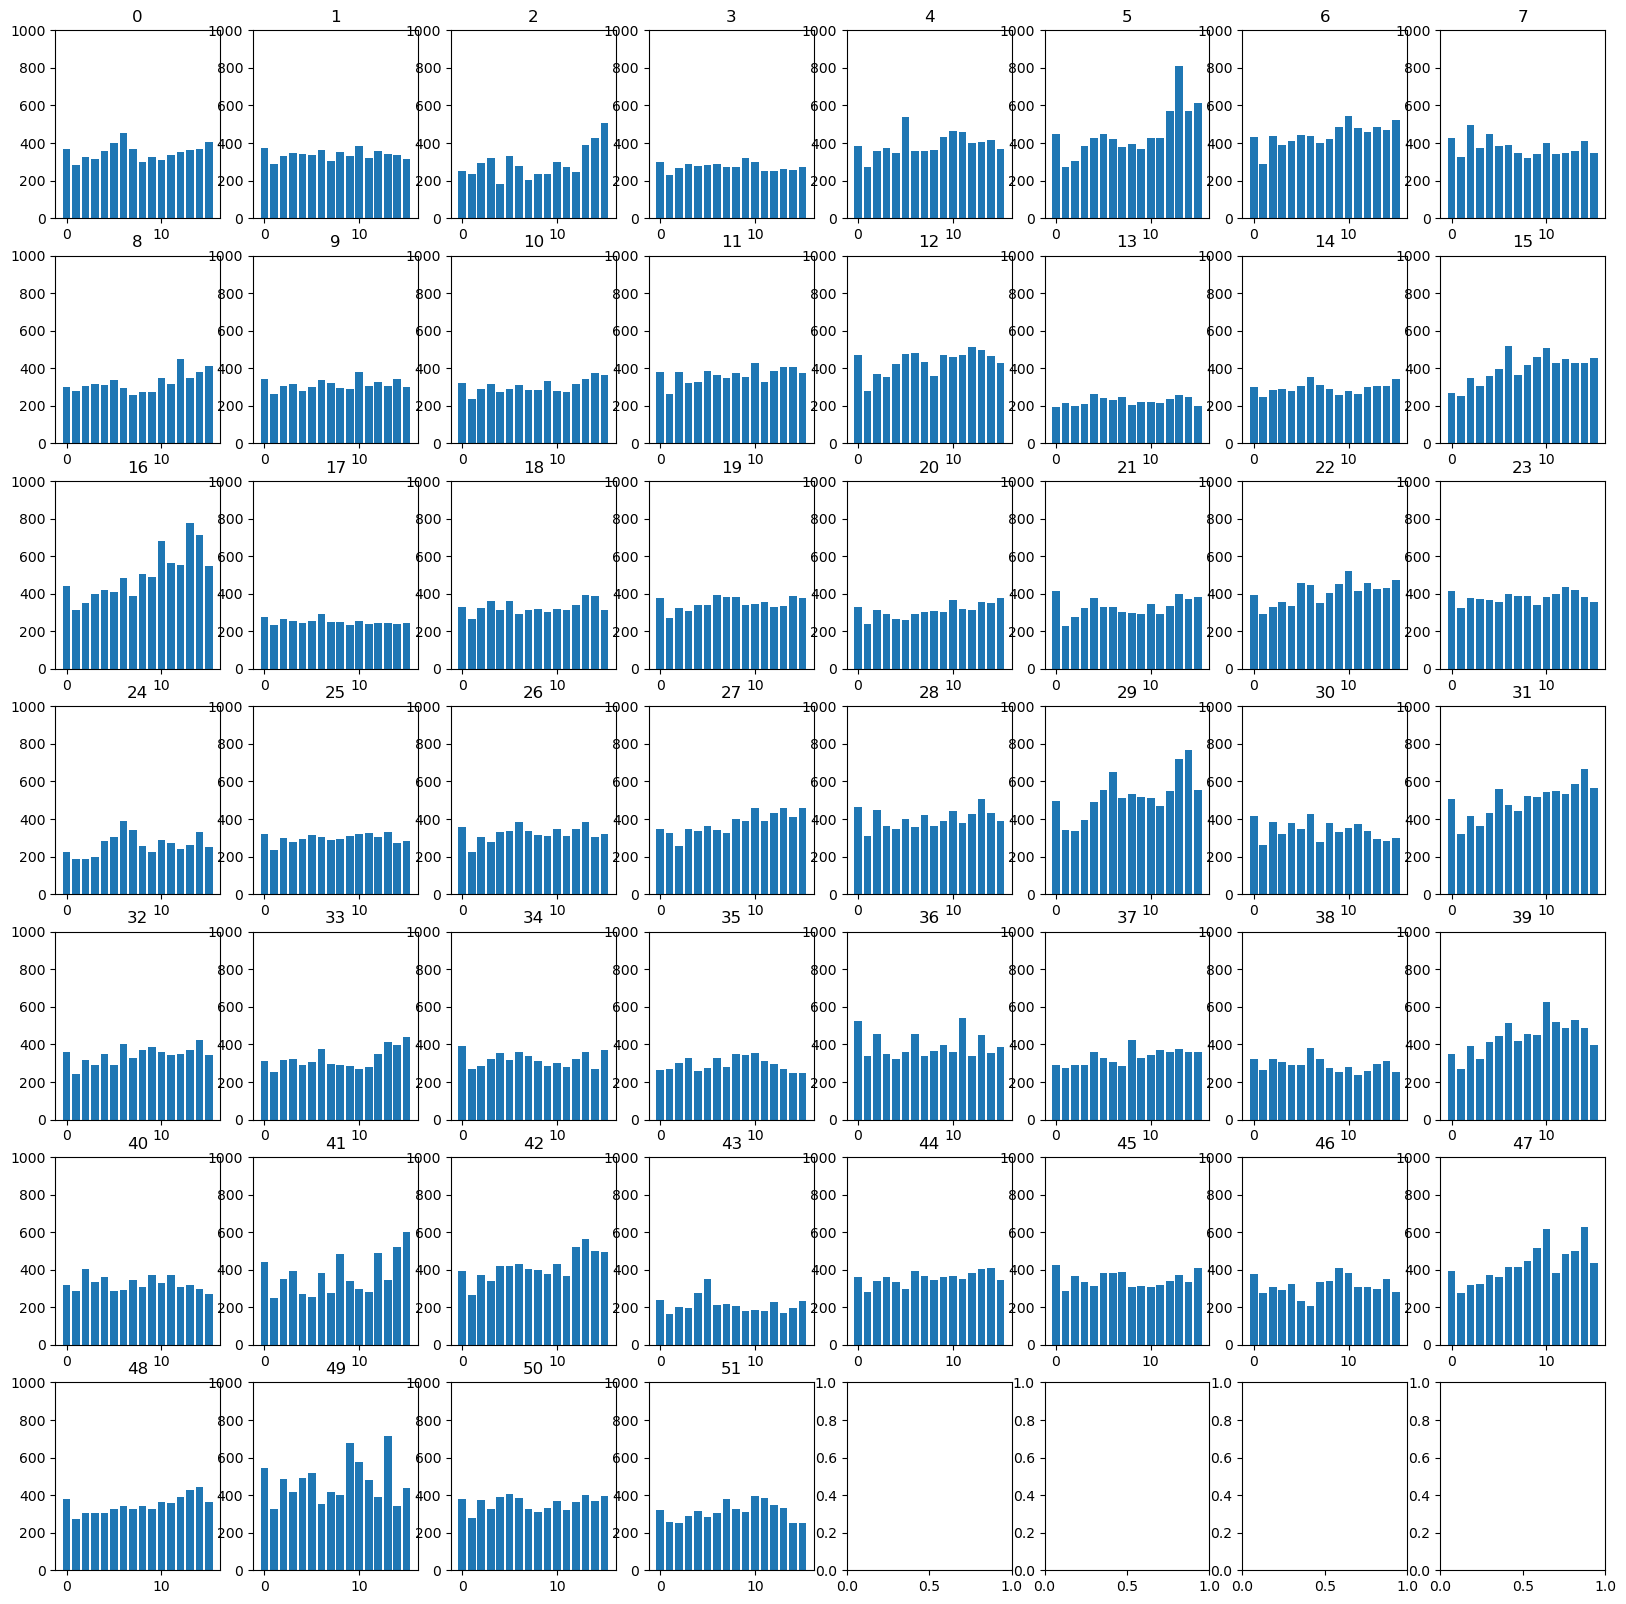

In [30]:
avg_fixation_duration.round(2)

fig, axs = plt.subplots(7,8)
axs = axs.flatten()
fig.set_size_inches(20,20)

for ind, ax in enumerate(axs) :
    ax.bar(range(16), avg_fixation_duration[ind])
    ax.set_ylim(0,1000)
    ax.set_title(ind)

fig.tight_layout()

IndexError: index 52 is out of bounds for axis 0 with size 52

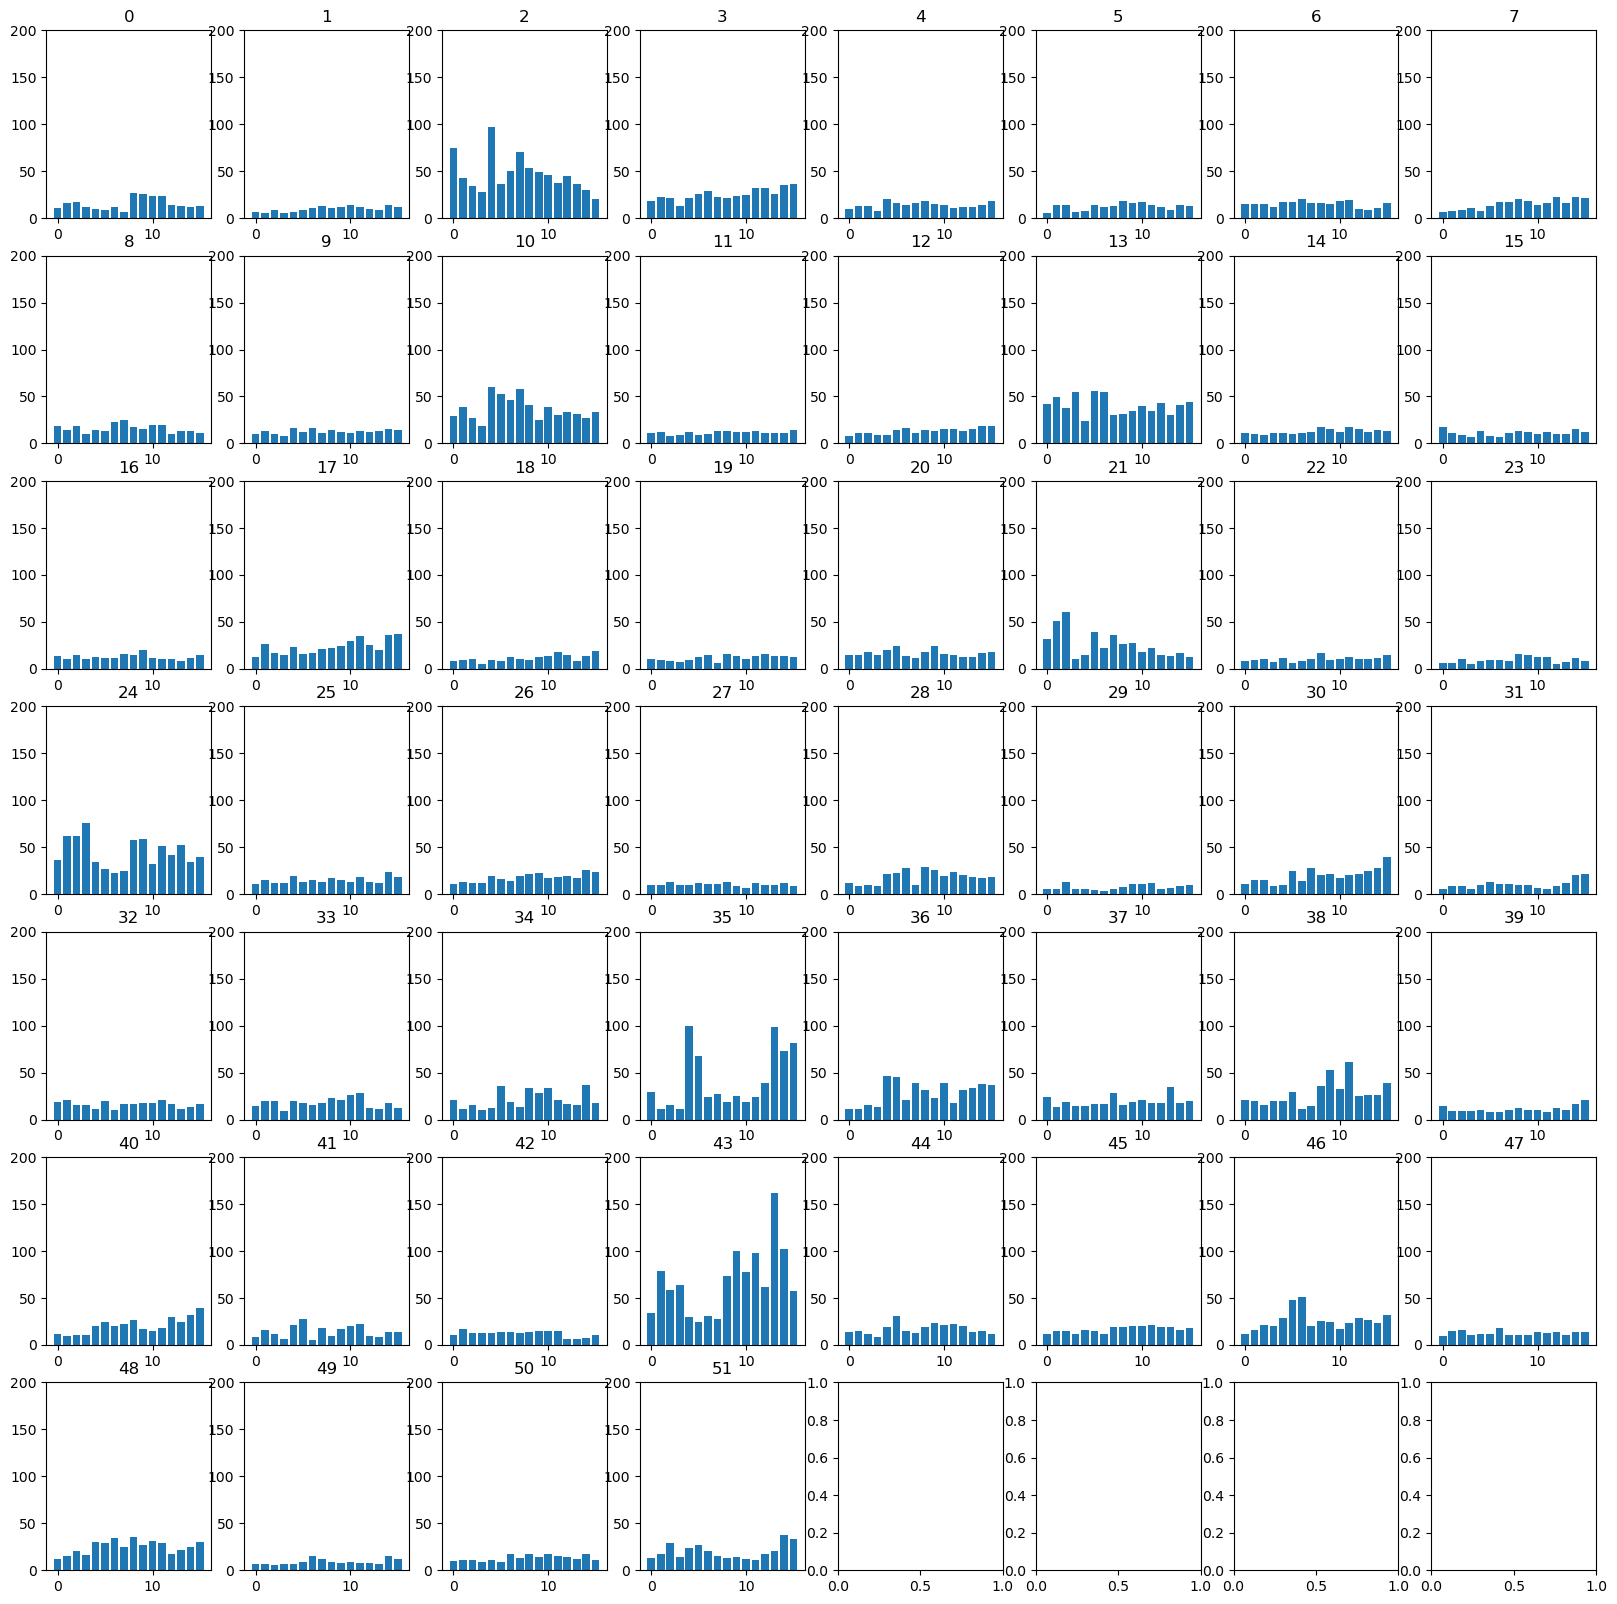

In [ ]:
avg_saccade_duration.round(2)

fig, axs = plt.subplots(7,8)
axs = axs.flatten()
fig.set_size_inches(20,20)

for ind, ax in enumerate(axs) :
    ax.bar(range(16), avg_saccade_duration[ind])
    ax.set_ylim(0,200)
    ax.set_title(ind)

fig.suptitle("Fixation dutaiton")
fig.tight_layout()